# 读取分子

In [2]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd

In [63]:

columns_to_read = ['number_id', 's_sd_Smiles', 'r_i_docking_score', 's_lp_Variant']
mol_frame1 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine1_vs_5-SP_OUT_1.csv', usecols=columns_to_read)
mol_frame2 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine2_vs_2-SP_OUT_1.csv', usecols=columns_to_read)
mol_frame3 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine3_vs_2-XP_OUT_1.csv', usecols=columns_to_read)
mol_frame4 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine4_vs_1-SP_OUT_1.csv', usecols=columns_to_read)
mol_frame5 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine5_vs_1-SP_OUT_1.csv', usecols=columns_to_read)
mol_frame6 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine6_vs_1-SP_OUT_1.csv', usecols=columns_to_read)
mol_frame7 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine7_vs_1-SP_OUT_1.csv', usecols=columns_to_read)
mol_frame8 = pd.read_csv('/home/xxyu/ALDH2/enamine_linux/enamine8_vs_1-SP_OUT_1.csv', usecols=columns_to_read)


combined_mol = pd.concat([mol_frame1, mol_frame2, mol_frame3, mol_frame4, mol_frame5, mol_frame6, mol_frame7, mol_frame8])
combined_mol.tail(3)

# 根据docking进行排序
sorted_df = combined_mol.sort_values(by='r_i_docking_score')

sorted_df = sorted_df.head(1600)
sorted_df.reset_index(drop=True, inplace=True)
# sorted_df.head(1000)

mol_id = sorted_df['number_id']
mol_smiles = sorted_df['s_sd_Smiles']
docking_score = sorted_df['r_i_docking_score']
molfile_name = sorted_df['s_lp_Variant']


mol_list = []
for i in mol_smiles:
    mol = Chem.MolFromSmiles(i)
    mol_list.append(mol)
mol_scaffolds_list = []

sorted_df.tail(5)


,number_id,s_lp_Variant,s_sd_Smiles,r_i_docking_score
1595,1-134,ligprep_enamine1.sdf:73659-1,CC(c1cc(NS(C)(=O)=O)ccc1)NC(c2cc(c3cc2)CCO3)=O,-9.356123
1596,2-118,ligprep_enamine2.sdf:247847-2,NCC1C(NC(c2c(F)ccc(N3C(=O)CCC3)c2)=O)CCC1,-9.355951
1597,6-124,ligprep_enamine6.sdf:240870-1,Cc1c(C)c(c2onc(c3cc(C(F)(F)F)ccc3)n2)cc(S(N)(=...,-9.355583
1598,8-116,ligprep_enamine8.sdf:40031-1,CCC1Cc(c2CC1)cc(c3n(C)c(SCC(N)=O)nn3)s2,-9.355368
1599,6-125,ligprep_enamine6.sdf:156475-2,Cc1c(n2ccc1)nc(CN3c(c4OC(C(N)=O)C3)cccc4)c2,-9.354883


# 基于Murcko骨架的聚类

In [60]:
scaffolds = {}
clusters_list =[]

idx = 1
for mol in mol_list:
    scaffold_smi =  MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
    if scaffold_smi not in scaffolds.keys():
        scaffolds[scaffold_smi] = idx
        idx+=1
        
    cluster_id = scaffolds[scaffold_smi]    # 同一种骨架的会有相同的cluster_id
    clusters_list.append(cluster_id)        # 记录每个分子的cluster_id
print("分子的个数:",len(mol_list))
print("Murcko骨架的个数:",len(scaffolds.keys()))


分子的个数: 1600
Murcko骨架的个数: 662


# 查看某一种骨架的化合物

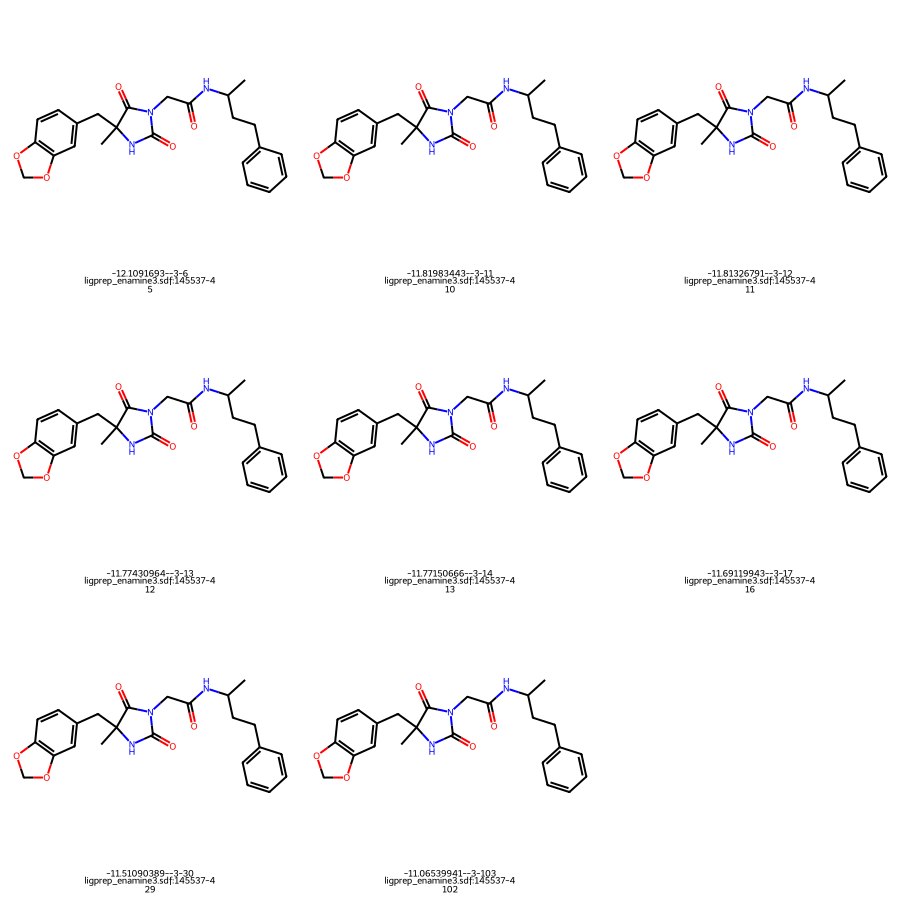

In [47]:
clusters_list = np.array(clusters_list)
# 返回某种骨架所对应化合物的索引
idx_c15 = np.where(clusters_list==)[0]


mol_list_c15 = [mol_list[i] for i in idx_c15]



mol_legend = [str(docking_score[i]) + '--' +  str(mol_id[i]) + '\n' + str(molfile_name[i]) + '\n' + str(i) for i in idx_c15]

Draw.MolsToGridImage(mol_list_c15, molsPerRow=3, subImgSize=(300,300), legends=mol_legend)

# 化合物去重

In [64]:
mol_filter = sorted_df.drop_duplicates(subset='s_sd_Smiles')
mol_filter.shape

(889, 4)

In [62]:
mol_filter.to_csv('mol_uni.csv', index=False)

# 将title和smiles相匹配

In [1]:
import pandas as pd

In [2]:
smiles_df = pd.read_csv('./mol_uni_1.csv')
columns_to_read = ['Title', 'docking score', 'glide gscore', 'MMGBSA dG Bind']  # 假设我们只想要读取这几列
title_df = pd.read_csv('./molfilter_top1000_choose.csv', usecols=columns_to_read)

smiles_list = smiles_df['smiles'].tolist()
title_list = smiles_df['comid'].tolist()
tilte_choose = title_df['Title'].tolist()

In [3]:
smiles_choose = []
for i in tilte_choose:
    index = title_list.index(i)
    smiles_tem = smiles_list[index]
    smiles_choose.append(smiles_tem)

title_df['smiles'] = smiles_choose

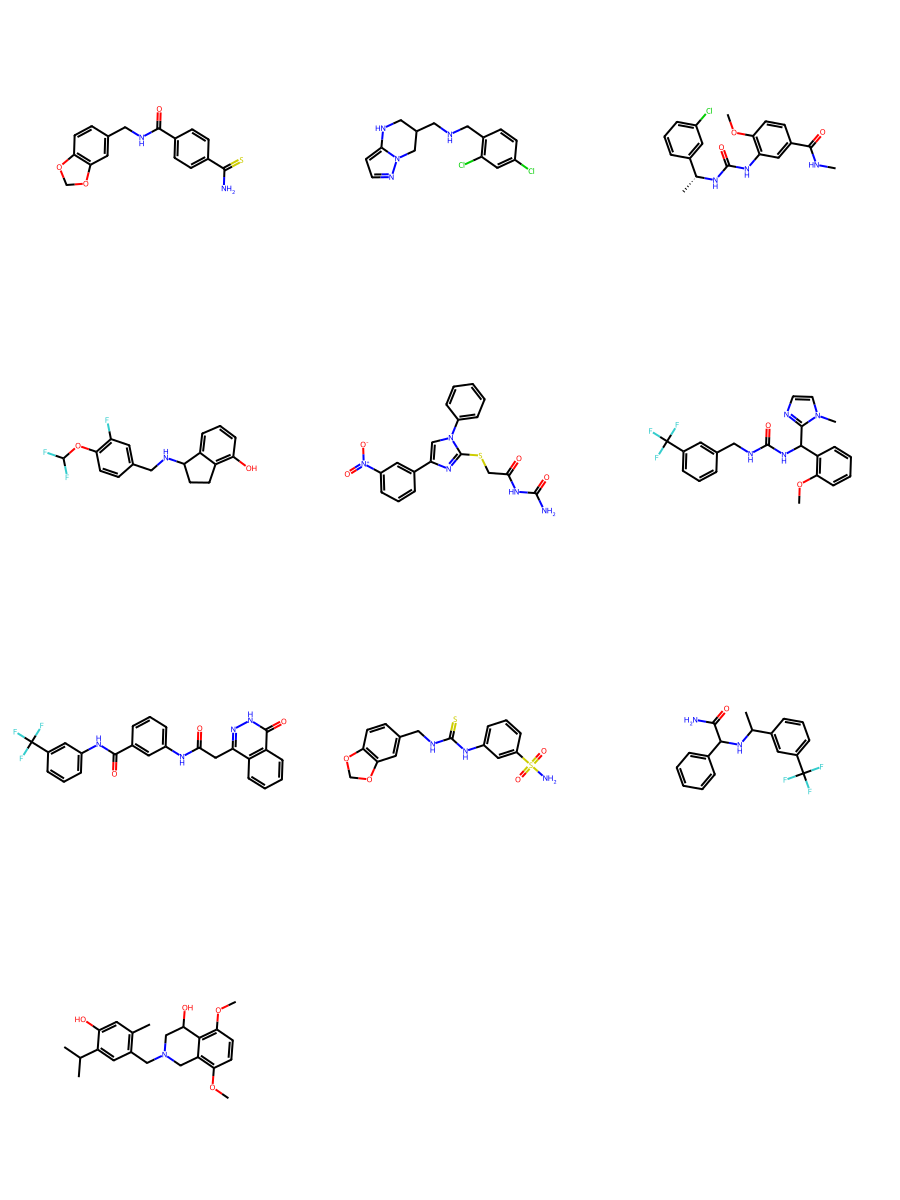

In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import IPythonConsole

mols = []
for i in smiles_choose[:10]:
    mol_tem = Chem.MolFromSmiles(i)
    mols.append(mol_tem)

Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,300))


# 将数据整合到一个excel中

In [5]:
docking_score_list = title_df['docking score'].tolist()
mmgbsa_list = title_df['MMGBSA dG Bind'].tolist()
smiles_choose_list = title_df['smiles'].tolist()

In [14]:
import pandas as pd 
import xlsxwriter
import openpyxl
from openpyxl.styles import Alignment

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions

align = Alignment(horizontal='center', vertical='center',wrapText=True)
# 读入要处理的数据
# df = pd.read_excel('dataset.xlsx', engine='openpyxl',header=None)

# 根据smiles编码生成图片，生成的图片挡在generation文件夹中
def generation_images(data):
    draw = data
    for i,j in enumerate(draw):
        mol = Chem.MolFromSmiles(j)
        Draw.MolToFile(mol,f'./file_img/img{i}.png',size=(300,300))

# 创建excel表格，将生成的图片读入
def load_images(data):
    # 读取工作薄
    workbook = xlsxwriter.Workbook('./xx1.xlsx')
    # 创建sheet表单
    worksheet = workbook.add_worksheet()
    centered_format = workbook.add_format()
    centered_format.set_align('center')
    centered_format.set_align('vcenter')
    for i,j in enumerate(data):
        worksheet.write(f'A{i+1}', f'{j}')
        worksheet.insert_image(f'B{i+1}', f'./file_img/img{i}.png')
        worksheet.write(f'C{i+1}', f'{docking_score_list[i]}')
        worksheet.write(f'D{i+1}', f'{mmgbsa_list[i]}')
        # worksheet.set_row(i, 300)  # 调整行高
        worksheet.set_row(i, 226, centered_format)  # 应用居中格式

    worksheet.set_column('A:A', 30)  # 调整列宽
    worksheet.set_column('B:B', 42)  # 调整列宽
    worksheet.set_column('C:C', 20)  # 调整列宽
    worksheet.set_column('D:D', 20)  # 调整列宽


    # for g in range(1, worksheet.max_row + 1):
    #     for h in range(1, worksheet.max_column + 1):
    #         worksheet.cell(g, h).alignment = align
    workbook.close()

# generation_images(smiles_choose_list)
load_images(smiles_choose_list)

In [5]:
import pandas as pd
with pd.ExcelWriter('test.xlsx') as writer:
    df.to_excel(writer, sheet_name='data')

ModuleNotFoundError: No module named 'openpyxl'

In [ ]:
# 